In [2]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.read_csv("data/PTSD_cognet_test.csv")

,record_id,PTSDDx,ptsd1,ptsd2,ptsd3,ptsd4,ptsd5,ptsd6,ptsd7,ptsd8,...,ptsd202,ptsd203,ptsd204,ptsd205,ptsd206,ptsd207,ptsd208,ptsd209,ptsd210,ptsd211
0,CAT1001,0,4,2,5,4,2,3,2,3,...,2,4,4,3,2,3,2,2,4,2
1,CAT1002,0,3,2,3,3,1,3,2,2,...,3,4,4,3,3,3,4,3,4,5
2,CAT1003,0,2,2,2,4,1,3,3,2,...,4,2,2,4,4,2,3,2,2,5
3,CAT1004,0,2,2,5,1,3,2,1,2,...,1,2,3,3,3,2,1,1,2,2
4,CAT1005,0,4,1,1,1,2,2,1,1,...,2,2,2,2,1,1,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,CAT1300,1,4,2,3,4,1,1,1,1,...,2,2,2,2,2,2,2,2,2,3
300,CAT1301,1,5,2,2,4,4,3,2,5,...,5,5,5,5,4,5,5,4,4,5
301,CAT1302,0,5,1,2,1,1,3,5,5,...,4,3,3,2,3,1,3,2,5,5
302,CAT1303,0,2,1,3,3,1,2,2,2,...,1,1,1,1,1,2,2,2,2,2


In [4]:
pd.read_csv("data/PTSD_cognet_test_processed.csv")

,ptsd1,ptsd2,ptsd3,ptsd4,ptsd5,ptsd6,ptsd7,ptsd8,ptsd9,ptsd10,...,ptsd202,ptsd203,ptsd204,ptsd205,ptsd206,ptsd207,ptsd208,ptsd209,ptsd210,ptsd211
0,4,2,5,4,2,3,2,3,3,2,...,2,4,4,3,2,3,2,2,4,2
1,3,2,3,3,1,3,2,2,2,1,...,3,4,4,3,3,3,4,3,4,5
2,2,2,2,4,1,3,3,2,2,4,...,4,2,2,4,4,2,3,2,2,5
3,2,2,5,1,3,2,1,2,2,1,...,1,2,3,3,3,2,1,1,2,2
4,4,1,1,1,2,2,1,1,1,2,...,2,2,2,2,1,1,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,4,2,3,4,1,1,1,1,3,2,...,2,2,2,2,2,2,2,2,2,3
300,5,2,2,4,4,3,2,5,4,4,...,5,5,5,5,4,5,5,4,4,5
301,5,1,2,1,1,3,5,5,3,4,...,4,3,3,2,3,1,3,2,5,5
302,2,1,3,3,1,2,2,2,1,1,...,1,1,1,1,1,2,2,2,2,2


In [5]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/PTSD_cognet_test_processed.csv")

In [6]:
Tr.fit(modelpath="tmp_Qnet.joblib")

In [7]:
Tr.model_obj.myQnet.feature_names

['ptsd1',
 'ptsd2',
 'ptsd3',
 'ptsd4',
 'ptsd5',
 'ptsd6',
 'ptsd7',
 'ptsd8',
 'ptsd9',
 'ptsd10',
 'ptsd11',
 'ptsd12',
 'ptsd13',
 'ptsd14',
 'ptsd15',
 'ptsd16',
 'ptsd17',
 'ptsd18',
 'ptsd19',
 'ptsd20',
 'ptsd21',
 'ptsd22',
 'ptsd23',
 'ptsd24',
 'ptsd25',
 'ptsd26',
 'ptsd27',
 'ptsd28',
 'ptsd29',
 'ptsd30',
 'ptsd31',
 'ptsd32',
 'ptsd33',
 'ptsd34',
 'ptsd35',
 'ptsd36',
 'ptsd37',
 'ptsd38',
 'ptsd39',
 'ptsd40',
 'ptsd41',
 'ptsd42',
 'ptsd43',
 'ptsd44',
 'ptsd45',
 'ptsd46',
 'ptsd47',
 'ptsd48',
 'ptsd49',
 'ptsd50',
 'ptsd51',
 'ptsd52',
 'ptsd53',
 'ptsd54',
 'ptsd55',
 'ptsd56',
 'ptsd57',
 'ptsd58',
 'ptsd59',
 'ptsd60',
 'ptsd61',
 'ptsd62',
 'ptsd63',
 'ptsd64',
 'ptsd65',
 'ptsd66',
 'ptsd67',
 'ptsd68',
 'ptsd69',
 'ptsd70',
 'ptsd71',
 'ptsd72',
 'ptsd73',
 'ptsd74',
 'ptsd75',
 'ptsd76',
 'ptsd77',
 'ptsd78',
 'ptsd79',
 'ptsd80',
 'ptsd81',
 'ptsd82',
 'ptsd83',
 'ptsd84',
 'ptsd85',
 'ptsd86',
 'ptsd87',
 'ptsd88',
 'ptsd89',
 'ptsd90',
 'ptsd91',
 'ptsd92

In [8]:
Tr.getDissonance(outfile="mpi_tmp/PTSD_dissonance_matrix2.csv")

In [9]:
import random

new_samp = np.full_like(samples[0], fill_value="")
vals = ["1", "2", "3", "4", "5"]
mean_diss_r = list()

for i in range(211):
    new_samp[i] = random.choice(vals)
    mean_diss_r.append(np.mean(Tr.cognet_obj.dissonance(sample=new_samp)))

In [10]:
from quasinet.utils import sample_from_dict

new_samp = np.full_like(samples[0], fill_value="")
mean_diss_q = list()

for i in range(211):
    prob_dict = Tr.model_obj.myQnet.predict_distribution(new_samp, i)
    new_samp[i] = sample_from_dict(prob_dict)
    mean_diss_q.append(np.mean(Tr.cognet_obj.dissonance(sample=new_samp)))

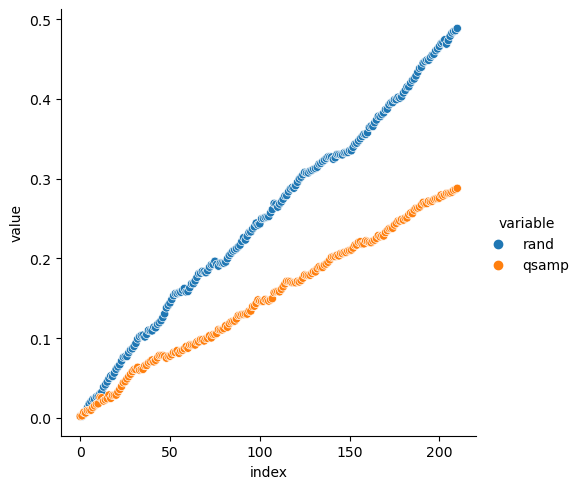

In [11]:
sns.relplot(
    data=pd.melt(
        pd.DataFrame({"rand": mean_diss_r, "qsamp": mean_diss_q}).reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
)